Handwritten Digit Classification using Multiplayer Perceptron

In [31]:
#Importing Necessary Packages

import torch # Used to Create tensors (for efficient Computation)
import torch.nn as nn # Importing Base Neural network model from torch.nn package
import torch.optim as optim # Used to Update HyperParameters (Weights and Bias)
import torchvision.transforms as transforms #Used to apply Transformation on tensors
import torchvision.datasets as datasets # To access inbuilt Datasets
from torch.utils.data import DataLoader # Used to Provide batches of data to model during training
import matplotlib.pyplot as plt # Used to Visualize the Data 
import seaborn as sns # Data Visualization Library
from sklearn.metrics import confusion_matrix,classification_report # Confusion Matrix is used to Evaluate the model

Loading The Datasets

In [2]:
# Loading The MNIST dataset from Datasets module
""" 
transforms.Compose() is used to create a Transformation Pipeline which will execute one by one
transforms.ToTensor() method is used to convert data into Tensors. It convert all the datapoints in range of [0,1)
transforms.Normalize((mean),(std)) method is used to make data 0 centric (Best for neural network). It convert all the datapoints in range of [-1,1]
"""
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
"""
datasets.MNIST() contains handwritten digits image dataset
root="./data" specifies the directory where the data is present
train=True(or False) Specifies Whether the dataset is training dataset or testing dataset
transform=transform is used to apply transformationm pipeline on the Obtained data
download=True It tells the interpreter to download the data from the internet and store it in root directory 
"""
train_dataset=datasets.MNIST(root="./data",train=True, transform=transform,download=True)
test_dataset=datasets.MNIST(root="./data",train=False, transform=transform,download=True)

100%|██████████| 9.91M/9.91M [00:30<00:00, 330kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 94.9kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.47MB/s]


In [4]:
# printing the length of datasets
len(train_dataset),len(test_dataset)

(60000, 10000)

In [16]:
# Define dataLoaders
train_loader=DataLoader(dataset=train_dataset,batch_size=64,shuffle=True) 
test_loader=DataLoader(dataset=test_dataset,batch_size=64,shuffle=True)

#DataLoader return Iter object consisting batches of batch size attributes
data_iter=iter(train_loader)
image,label=next(data_iter)

In [18]:
image.shape,label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [20]:
image[0].squeeze().shape

torch.Size([28, 28])

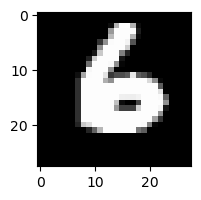

In [21]:
plt.figure(figsize=(2,2))
plt.imshow(image[0].squeeze(),cmap="gray")
plt.show()

In [22]:
label[0]

tensor(6)

Trainning a Fully connected Neural Network

In [26]:
# Create a class for our model which inherit the module class of our neural network

class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            # to Flatten the Tensor
            nn.Flatten(),
            # 28*28 is the shape of Image
            nn.Linear(28*28,128),
            # Activation function 
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self,x):
        return self.network(x)

In [27]:
#Instantiate the model, define loss function and optimizer
model=DigitClassifier()
# CrossEntropyLoss is Generally Used for Classification problems (It Find the dissimilarity between two metrices and compute loss) 
criterion= nn.CrossEntropyLoss() 
# Optimizer updates the internal setting to train our model
# Adam stands for Adaptive moment Estimation which uses different learning rates for each weight to update
optimizer=optim.Adam(model.parameters(),lr=0.001)

# Training the model
epochs=5

for epoch in range(epochs):
    running_loss=0.0
    for images, labels in train_loader:
        optimizer.zero_grad() # Setting the initial gradient zero
        output=model(images)# Forward Pass
        loss=criterion(output,labels) # Computing Loss
        loss.backward() # Backpropogate the loss
        optimizer.step() # Update Weights

        running_loss +=loss.item()
        
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.3958
Epoch [2/5], Loss: 0.1899
Epoch [3/5], Loss: 0.1365
Epoch [4/5], Loss: 0.1120
Epoch [5/5], Loss: 0.0944


In [28]:
# Testing The Model
model.eval() # Switching to evaluation mode
correct=0
total=0

with torch.no_grad():
    for images, labels in test_loader:
        # Predict the labels on Test data using test loaders 
        output=model(images)
        # Output consist a Tensor of 10 values along with their indices 
        # we obtain max value then ignore the value (by assigning to _) and return the indices as predicted
        _,predicted=torch.max(output.data,1)
        total+=labels.size(0)
        correct+= (predicted==labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 96.71%


Classification Report and Confusion matrix

In [29]:
# Evaluating the model
model.eval()

all_predicted=[]
all_labels=[]

with torch.no_grad():
    for images,labels in test_loader:
        output=model(images)
        _,predicted=torch.max(output.data,1)

        all_labels.extend(labels.numpy())
        all_predicted.extend(predicted.numpy())

In [30]:
len(all_predicted)

10000

In [32]:
report =classification_report(all_labels,all_predicted)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.94      0.99      0.96       958
           7       0.95      0.97      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.98      0.93      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [33]:
cm=confusion_matrix(all_labels,all_predicted)
cm

array([[ 968,    0,    1,    1,    0,    2,    6,    1,    1,    0],
       [   0, 1119,    2,    3,    0,    2,    6,    2,    1,    0],
       [   6,    0, 1001,    4,    1,    0,    7,   10,    3,    0],
       [   1,    0,    4,  978,    0,   10,    1,    7,    8,    1],
       [   1,    1,    3,    1,  943,    1,   19,    3,    1,    9],
       [   6,    0,    0,   11,    1,  858,   11,    2,    3,    0],
       [   4,    3,    0,    0,    3,    2,  945,    0,    1,    0],
       [   1,    4,   13,    6,    0,    1,    1,  997,    1,    4],
       [   6,    4,    4,    5,    2,   11,   10,    8,  922,    2],
       [   3,    5,    1,    6,   14,   12,    3,   14,   11,  940]])

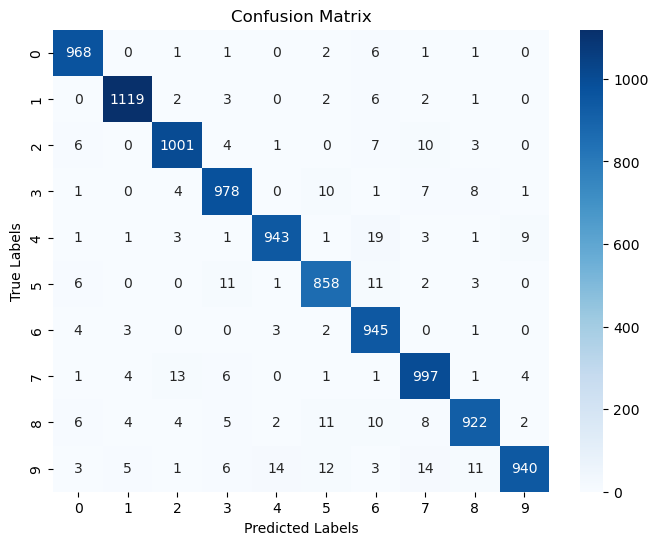

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True, fmt="d", cmap="Blues", xticklabels=range(len(cm)),yticklabels=range(len(cm)))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()